In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4.1-nano",temperature=0)

In [4]:
from langgraph.graph import MessagesState

class RaceSessionState(MessagesState):
    race_summary: str

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_race_control(state: RaceSessionState):
    summary = state.get("race_summary", "")
    if summary:
        system_message = f"Summary of the race session so far: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [6]:
def generate_race_report(state: RaceSessionState):
    summary = state.get("race_summary", "")
    if summary:
        summary_message = (
            f"This is the race report so far: {summary}\n\n"
            "Update the report based on the new radio messages above:"
        )
    else:
        summary_message = "Generate a brief race report based on the radio messages above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"race_summary": response.content, "messages": delete_messages}

In [7]:
from langgraph.graph import END
from typing_extensions import Literal

def should_generate_report(state: RaceSessionState) -> Literal ["generate_race_report", END]:
    messages = state["messages"]
    if len(messages) > 6:
        return "generate_race_report"
    return END

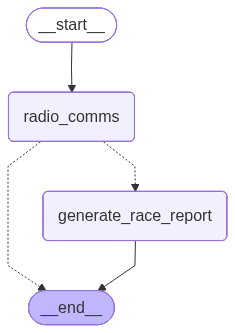

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(RaceSessionState)
workflow.add_node("radio_comms", call_race_control)
workflow.add_node(generate_race_report)

workflow.add_edge(START, "radio_comms")
workflow.add_conditional_edges("radio_comms", should_generate_report)
workflow.add_edge("generate_race_report", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "race_1"}}

input_message = HumanMessage(content="Box this lap, box for hards.", name="RaceEngineer")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Copy that.", name="Driver")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Traffic behind, Leclerc +2.5s", name="RaceEngineer")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Understood. Box this lap for hard tires.
================================== Ai Message ==================================

Copy that. Proceeding to box for hard tires.
================================== Ai Message ==================================

Acknowledged. Traffic behind, Leclerc is +2.5 seconds. Keep an eye on him.


In [10]:
graph.get_state(config).values.get("race_summary","")

''

In [11]:
input_message = HumanMessage(content="Tyres are starting to go.", name="Driver")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Understood. Monitor tire wear closely. Consider pushing or planning your next pit stop accordingly.


In [12]:
graph.get_state(config).values.get("race_summary","")

'During the race, the driver was instructed to box for hard tires, with the race engineer noting traffic behind, specifically Leclerc at +2.5 seconds. The driver acknowledged the call, and tire wear was reported to be starting to go, prompting a focus on monitoring tire degradation and planning for upcoming strategy adjustments.'